# PTBXL Novelty Detection with Counterfactual Explanations

3 layer explainable AI pipeline for time series novelty detection:

1. **Detection Layer** - Compare novelty detection methods (CNN-AE, IF, OCSVM, LOF, ....)
2. **Counterfactual Layer** - uses nearest neighbour approach to generate counterfactual explanations
3. **LLM Quality Filter** - LLM \(open ai) to evaluate counterfactual explanations

## Dataset
PTBXL - a large publicly available electrocardiography dataset:
- 21837 clinical 12 lead ecg recordings
- 10 second recordings at 100 hz (1000 samples)
- Annotated with diagnostic statements

## Novelty Detection Approach
The detectors are trained ONLY on normal samples (semi supervised novelty detection). Learn the distribution of normal and flag deviations from it as novel/ anomalous.

---
## 1. Setup & Configuration

In [40]:
%pip install wfdb numpy pandas scipy scikit-learn matplotlib seaborn openai tqdm torch --quiet

import numpy as np
import pandas as pd
from pathlib import Path
import warnings
import time
import os
import ast
import json
import wfdb
from scipy import signal
from scipy.stats import skew, kurtosis, ttest_ind
from scipy.spatial.distance import cdist, euclidean
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    roc_curve, precision_recall_curve
)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Literal
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
from tqdm import tqdm
from openai import OpenAI

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [41]:
@dataclass
class PipelineConfig:    
    # Dataset
    dataset: str = 'ptbxl'
    data_dir: str = '../PTBXL-old/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
    sampling_rate: int = 100
    signal_length: int = 1000
    n_channels: int = 12
    
    # Preprocessing
    lowcut: float = 0.5
    highcut: float = 40.0
    filter_order: int = 4
    
    # Detection 
    contamination: float = 0.1
    
    # Isolation Forest
    if_n_estimators: int = 100
    if_max_samples: str = 'auto'
    if_max_features: float = 1.0
    
    # One-Class SVM
    svm_kernel: str = 'rbf'
    svm_nu: float = 0.1
    svm_gamma: str = 'scale'
    
    # Local Outlier Factor
    lof_n_neighbors: int = 20
    
    # CNN Autoencoder
    cnn_epochs: int = 30
    cnn_batch_size: int = 64
    cnn_lr: float = 1e-3
    cnn_weight_decay: float = 1e-4
    cnn_reconstruction_percentile: float = 95.0
    
    # Counterfactual
    n_neighbors: int = 5
    distance_metric: str = 'euclidean'
    cf_search_k: int = 50
    
    # LLM
    llm_model: str = 'gpt-4o-mini'
    llm_temperature: float = 0.2
    llm_max_tokens: int = 512
    llm_api_key_env: str = 'OPENAI_API_KEY'
    
    # Primary detector for counterfactual generation
    primary_detector: str = 'isolation_forest'

    def __repr__(self) -> str:
        return (
            f"PipelineConfig(\n"
            f"  dataset='{self.dataset}',\n"
            f"  sampling_rate={self.sampling_rate}Hz,\n"
            f"  signal_length={self.signal_length},\n"
            f"  n_channels={self.n_channels},\n"
            f"  data_dir='{self.data_dir}'\n"
            f")"
        )
    
config = PipelineConfig()
print(f"Pipeline configured with: {config}")

Pipeline configured with: PipelineConfig(
  dataset='ptbxl',
  sampling_rate=100Hz,
  signal_length=1000,
  n_channels=12,
  data_dir='../PTBXL-old/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
)


---
## 2. Data Loading

In [42]:
class PTBXLDataLoader:    
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.metadata = None
        self.scp_statements = None
    
    def _parse_scp_codes(self, scp_codes_str: str) -> dict:
        try:
            if pd.isna(scp_codes_str):
                return {}
            return ast.literal_eval(scp_codes_str)
        except:
            return {}
    
    def _aggregate_diagnostic_codes(self, scp_codes: dict) -> dict:
        if self.scp_statements is None:
            return {}
        superclass_scores = {}
        for code, likelihood in scp_codes.items():
            if code in self.scp_statements.index:
                superclass = self.scp_statements.loc[code, 'diagnostic_class']
                if pd.notna(superclass):
                    if superclass not in superclass_scores:
                        superclass_scores[superclass] = likelihood
                    else:
                        superclass_scores[superclass] = max(superclass_scores[superclass], likelihood)
        return superclass_scores
    
    def _is_normal(self, scp_codes: dict) -> bool:
        if not scp_codes or 'NORM' not in scp_codes or scp_codes.get('NORM', 0) < 50:
            return False
        superclasses = self._aggregate_diagnostic_codes(scp_codes)
        high_conf = {k: v for k, v in superclasses.items() if v >= 50}
        return set(high_conf.keys()) == {'NORM'}
    
    def _is_anomaly(self, scp_codes: dict) -> bool:
        if not scp_codes:
            return False
        superclasses = self._aggregate_diagnostic_codes(scp_codes)
        for cls, likelihood in superclasses.items():
            if cls != 'NORM' and likelihood >= 50:
                return True
        return False
    
    def _load_signals(self, metadata: pd.DataFrame, data_path: Path) -> np.ndarray:
        signals = []
        filename_col = 'filename_lr' if self.config.sampling_rate == 100 else 'filename_hr'
        
        for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Loading signals"):
            try:
                filepath = data_path / row[filename_col]
                record = wfdb.rdrecord(str(filepath))
                sig = record.p_signal
                
                if sig.shape[0] >= self.config.signal_length:
                    sig = sig[:self.config.signal_length, :]
                else:
                    pad_length = self.config.signal_length - sig.shape[0]
                    sig = np.pad(sig, ((0, pad_length), (0, 0)), mode='edge')
                signals.append(sig)
            except Exception as e:
                print(f"Error loading {row[filename_col]}: {e}")
        return np.array(signals)
    
    def load(self, test_fold: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, pd.DataFrame, pd.DataFrame]:
        data_path = Path(self.config.data_dir)
        
        self.scp_statements = pd.read_csv(data_path / 'scp_statements.csv', index_col=0)
        self.metadata = pd.read_csv(data_path / 'ptbxl_database.csv', index_col='ecg_id')
        
        self.metadata['scp_codes_dict'] = self.metadata['scp_codes'].apply(self._parse_scp_codes)
        self.metadata['is_normal'] = self.metadata['scp_codes_dict'].apply(self._is_normal)
        self.metadata['is_anomaly'] = self.metadata['scp_codes_dict'].apply(self._is_anomaly)
        
        # Filter to strict normal OR clear anomaly
        valid_mask = self.metadata['is_normal'] | self.metadata['is_anomaly']
        filtered = self.metadata[valid_mask].copy()
        filtered['label'] = (~filtered['is_normal']).astype(int)
        
        print(f"\nDataset summary:")
        print(f"  Total records: {len(self.metadata)}")
        print(f"  Valid (used): {len(filtered)}")
        print(f"  Normal: {filtered['is_normal'].sum()}")
        print(f"  Anomaly: {filtered['is_anomaly'].sum()}")
        
        # Split by fold
        train_meta = filtered[filtered['strat_fold'] != test_fold]
        test_meta = filtered[filtered['strat_fold'] == test_fold]
        
        print(f"\nSplit (test fold {test_fold}):")
        print(f"  Train: {len(train_meta)} | Test: {len(test_meta)}")
        
        # Load signals
        X_train = self._load_signals(train_meta, data_path)
        X_test = self._load_signals(test_meta, data_path)
        y_train = train_meta['label'].values
        y_test = test_meta['label'].values
        
        print(f"\nData loaded: Train {X_train.shape}, Test {X_test.shape}")
        print(f"  Train - Normal: {np.sum(y_train==0)}, Anomaly: {np.sum(y_train==1)}")
        print(f"  Test  - Normal: {np.sum(y_test==0)}, Anomaly: {np.sum(y_test==1)}")
        
        return X_train, X_test, y_train, y_test, train_meta.reset_index(), test_meta.reset_index()

In [43]:
# Load data
data_loader = PTBXLDataLoader(config)
X_train_raw, X_test_raw, y_train, y_test, train_meta, test_meta = data_loader.load()


Dataset summary:
  Total records: 21799
  Valid (used): 20373
  Normal: 9038
  Anomaly: 11335

Split (test fold 10):
  Train: 18323 | Test: 2050


Loading signals: 100%|██████████| 2050/2050 [00:06<00:00, 303.64it/s]



Data loaded: Train (18323, 1000, 12), Test (2050, 1000, 12)
  Train - Normal: 8129, Anomaly: 10194
  Test  - Normal: 909, Anomaly: 1141


---
## 3. Preprocessing

In [44]:
class ECGPreprocessor:    
    def __init__(self, config: PipelineConfig):
        self.config = config
    
    def bandpass_filter(self, X: np.ndarray) -> np.ndarray:
        nyquist = self.config.sampling_rate / 2
        low = max(0.01, self.config.lowcut / nyquist)
        high = min(0.99, self.config.highcut / nyquist)
        b, a = signal.butter(self.config.filter_order, [low, high], btype='band')
        
        filtered = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[2]):
                filtered[i, :, j] = signal.filtfilt(b, a, X[i, :, j])
        return filtered
    
    def normalize(self, X: np.ndarray) -> np.ndarray:
        normalized = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[2]):
                sig = X[i, :, j]
                normalized[i, :, j] = (sig - np.mean(sig)) / (np.std(sig) + 1e-8)
        return normalized
    
    def preprocess(self, X: np.ndarray) -> np.ndarray:
        X_proc = np.nan_to_num(X.copy(), nan=0.0)
        X_proc = self.bandpass_filter(X_proc)
        X_proc = self.normalize(X_proc)
        return np.nan_to_num(X_proc, nan=0.0)

In [45]:
# Preprocess signals
preprocessor = ECGPreprocessor(config)
X_train = preprocessor.preprocess(X_train_raw)
X_test = preprocessor.preprocess(X_test_raw)

print(f"Preprocessing complete: Train {X_train.shape}, Test {X_test.shape}")

Preprocessing complete: Train (18323, 1000, 12), Test (2050, 1000, 12)


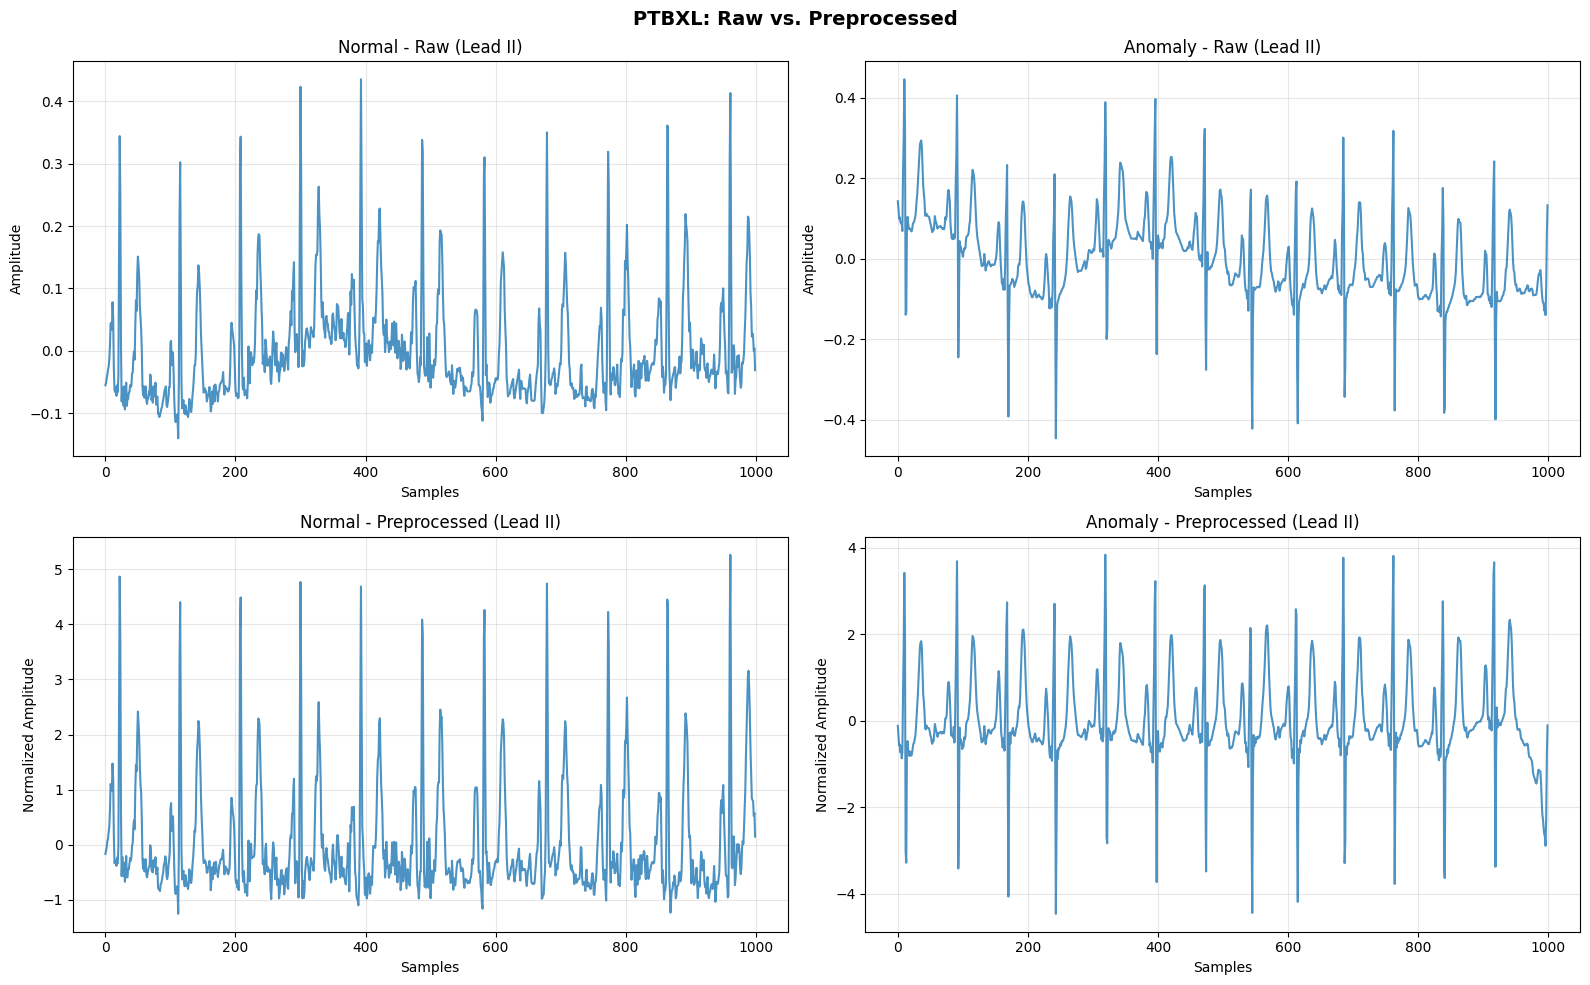

In [46]:
# Visualize sample ECGs
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Find examples
normal_idx = np.where(y_train == 0)[0][0]
anomaly_idx = np.where(y_train == 1)[0][0]

for col, (idx, label) in enumerate([(normal_idx, 'Normal'), (anomaly_idx, 'Anomaly')]):
    # Raw
    axes[0, col].plot(X_train_raw[idx, :, 1], alpha=0.8)  # Lead II
    axes[0, col].set_title(f'{label} - Raw (Lead II)')
    axes[0, col].set_xlabel('Samples')
    axes[0, col].set_ylabel('Amplitude')
    axes[0, col].grid(True, alpha=0.3)
    
    # Preprocessed
    axes[1, col].plot(X_train[idx, :, 1], alpha=0.8)
    axes[1, col].set_title(f'{label} - Preprocessed (Lead II)')
    axes[1, col].set_xlabel('Samples')
    axes[1, col].set_ylabel('Normalized Amplitude')
    axes[1, col].grid(True, alpha=0.3)

plt.suptitle('PTBXL: Raw vs. Preprocessed', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 4. Feature Extraction

In [47]:
class TimeSeriesFeatureExtractor:    
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.sampling_rate = config.sampling_rate
        self.n_channels = config.n_channels
        self.feature_names = []
        self._build_feature_names()
    
    def _build_feature_names(self):
        self.feature_names = []
        
        per_channel_features = [
            # Statistical
            'mean', 'std', 'var', 'min', 'max', 'range', 'median',
            'skewness', 'kurtosis', 'rms', 'zero_crossings',
            
            # Temporal/Peaks
            'n_peaks', 'peak_interval_mean', 'peak_interval_std', 'peak_interval_range',
            'peak_height_mean', 'peak_height_std', 'peak_regularity',
            
            # Frequency
            'total_power', 'low_freq_power', 'mid_freq_power', 'high_freq_power',
            'dominant_freq', 'spectral_entropy', 'spectral_centroid', 'bandwidth',
            
            # Autocorrelation
            'autocorr_lag1', 'autocorr_lag5', 'autocorr_lag10', 'trend_slope'
        ]
        
        # ECG lead names
        self.channel_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        
        # Per channel features with lead as the prefix
        for ch_name in self.channel_names:
            for feat in per_channel_features:
                self.feature_names.append(f"{ch_name}_{feat}")
        
        # interchannel features
        self.feature_names.extend([
            'channel_corr_mean', 'channel_corr_std',
            'cross_channel_std_mean', 'cross_channel_std_var'
        ])
    
    def _extract_statistical(self, x: np.ndarray) -> Dict[str, float]:
        return {
            'mean': float(np.mean(x)),
            'std': float(np.std(x)),
            'var': float(np.var(x)),
            'min': float(np.min(x)),
            'max': float(np.max(x)),
            'range': float(np.ptp(x)),
            'median': float(np.median(x)),
            'skewness': float(skew(x)),
            'kurtosis': float(kurtosis(x)),
            'rms': float(np.sqrt(np.mean(x**2))),
            'zero_crossings': float(np.sum(np.diff(np.signbit(x))))
        }
    
    def _extract_temporal(self, x: np.ndarray) -> Dict[str, float]:
        threshold = np.mean(x) + 0.5 * np.std(x)
        min_distance = max(1, len(x) // 50)
        
        try:
            peaks, _ = signal.find_peaks(x, height=threshold, distance=min_distance)
        except:
            peaks = np.array([])
        
        features = {'n_peaks': float(len(peaks))}
        
        if len(peaks) > 1:
            intervals = np.diff(peaks)
            features['peak_interval_mean'] = float(np.mean(intervals))
            features['peak_interval_std'] = float(np.std(intervals))
            features['peak_interval_range'] = float(np.ptp(intervals))
            features['peak_regularity'] = float(np.std(intervals) / (np.mean(intervals) + 1e-8))
        else:
            features['peak_interval_mean'] = 0.0
            features['peak_interval_std'] = 0.0
            features['peak_interval_range'] = 0.0
            features['peak_regularity'] = 0.0
        
        if len(peaks) > 0:
            peak_heights = x[peaks]
            features['peak_height_mean'] = float(np.mean(peak_heights))
            features['peak_height_std'] = float(np.std(peak_heights)) if len(peaks) > 1 else 0.0
        else:
            features['peak_height_mean'] = 0.0
            features['peak_height_std'] = 0.0
        
        return features
    
    def _extract_frequency(self, x: np.ndarray) -> Dict[str, float]:
        try:
            fft_vals = np.abs(np.fft.rfft(x))
            fft_freq = np.fft.rfftfreq(len(x), d=1/self.sampling_rate)  # has sampling rate
            
            total_power = np.sum(fft_vals**2) + 1e-8
            
            n_bins = len(fft_freq)
            low_mask = np.arange(n_bins) < n_bins // 3
            mid_mask = (np.arange(n_bins) >= n_bins // 3) & (np.arange(n_bins) < 2 * n_bins // 3)
            high_mask = np.arange(n_bins) >= 2 * n_bins // 3
            
            low_power = np.sum(fft_vals[low_mask]**2) / total_power
            mid_power = np.sum(fft_vals[mid_mask]**2) / total_power
            high_power = np.sum(fft_vals[high_mask]**2) / total_power
            
            psd_norm = fft_vals / (np.sum(fft_vals) + 1e-8)
            spectral_entropy = -np.sum(psd_norm * np.log(psd_norm + 1e-8))
            spectral_centroid = np.sum(fft_freq * fft_vals) / (np.sum(fft_vals) + 1e-8)
            bandwidth = np.sqrt(np.sum(((fft_freq - spectral_centroid)**2) * fft_vals) / (np.sum(fft_vals) + 1e-8))
            
            return {
                'total_power': float(total_power),
                'low_freq_power': float(low_power),
                'mid_freq_power': float(mid_power),
                'high_freq_power': float(high_power),
                'dominant_freq': float(fft_freq[np.argmax(fft_vals)]) if len(fft_vals) > 0 else 0.0,
                'spectral_entropy': float(spectral_entropy),
                'spectral_centroid': float(spectral_centroid),
                'bandwidth': float(bandwidth)
            }
        except:
            return {
                'total_power': 0.0, 'low_freq_power': 0.0, 'mid_freq_power': 0.0,
                'high_freq_power': 0.0, 'dominant_freq': 0.0, 'spectral_entropy': 0.0,
                'spectral_centroid': 0.0, 'bandwidth': 0.0
            }
    
    def _extract_autocorr(self, x: np.ndarray) -> Dict[str, float]:
        try:
            autocorr = np.correlate(x - np.mean(x), x - np.mean(x), mode='full')
            autocorr = autocorr[len(autocorr)//2:] / (autocorr[len(autocorr)//2] + 1e-10)
            
            return {
                'autocorr_lag1': float(autocorr[1]) if len(autocorr) > 1 else 0.0,
                'autocorr_lag5': float(autocorr[5]) if len(autocorr) > 5 else 0.0,
                'autocorr_lag10': float(autocorr[10]) if len(autocorr) > 10 else 0.0,
                'trend_slope': float(np.polyfit(np.arange(len(x)), x, 1)[0])
            }
        except:
            return {
                'autocorr_lag1': 0.0, 'autocorr_lag5': 0.0,
                'autocorr_lag10': 0.0, 'trend_slope': 0.0
            }
    
    # inter channel features for 12 lead ecg
    def _extract_inter_channel(self, X: np.ndarray) -> Dict[str, float]:
        n_channels = X.shape[1]
        
        # adjacent channel correlations
        correlations = []
        for i in range(n_channels - 1):
            try:
                corr = np.corrcoef(X[:, i], X[:, i+1])[0, 1]
                correlations.append(corr if not np.isnan(corr) else 0.0)
            except:
                correlations.append(0.0)
        
        # Cross channel variability
        channel_stds = [np.std(X[:, i]) for i in range(n_channels)]
        
        return {
            'channel_corr_mean': float(np.mean(correlations)) if correlations else 0.0,
            'channel_corr_std': float(np.std(correlations)) if len(correlations) > 1 else 0.0,
            'cross_channel_std_mean': float(np.mean(channel_stds)),
            'cross_channel_std_var': float(np.var(channel_stds))
        }
    
    # extract all the features from 1 channel with prefix
    def _extract_single_channel(self, x: np.ndarray, prefix: str) -> Dict[str, float]:
        features = {}
        
        for feat_dict in [
            self._extract_statistical(x),
            self._extract_temporal(x),
            self._extract_frequency(x),
            self._extract_autocorr(x)
        ]:
            for key, value in feat_dict.items():
                features[f"{prefix}_{key}"] = value
        
        return features
    
    def extract_single(self, signal_data: np.ndarray) -> np.ndarray:
        all_features = {}
        
        # Per channel features
        for ch_idx, ch_name in enumerate(self.channel_names):
            ch_features = self._extract_single_channel(signal_data[:, ch_idx], ch_name)
            all_features.update(ch_features)
        
        # Interchannel features
        inter_features = self._extract_inter_channel(signal_data)
        all_features.update(inter_features)
        
        return np.array([all_features.get(name, 0.0) for name in self.feature_names])
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        features = []
        for i in tqdm(range(len(X)), desc="Extracting features"):
            features.append(self.extract_single(X[i]))
        return np.array(features)

In [48]:
# Extract features
feature_extractor = TimeSeriesFeatureExtractor(config)

print(f"Extracting {len(feature_extractor.feature_names)} features per sample...")
X_train_features = feature_extractor.transform(X_train)
X_test_features = feature_extractor.transform(X_test)

# Handle NaN/Inf
imputer = SimpleImputer(strategy='median')
X_train_features = imputer.fit_transform(X_train_features)
X_test_features = imputer.transform(X_test_features)
X_train_features = np.nan_to_num(X_train_features, nan=0.0, posinf=0.0, neginf=0.0)
X_test_features = np.nan_to_num(X_test_features, nan=0.0, posinf=0.0, neginf=0.0)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

print(f"\n✓ Features extracted: {X_train_scaled.shape[1]} features")

Extracting 364 features per sample...


Extracting features: 100%|██████████| 2050/2050 [00:41<00:00, 49.18it/s]



✓ Features extracted: 364 features


In [49]:
# find the most discriminative features 
feature_scores = []
for i, feat_name in enumerate(feature_extractor.feature_names):
    normal_vals = X_train_features[y_train == 0, i]
    anomaly_vals = X_train_features[y_train == 1, i]
    
    # Effect size (Cohen's d)
    mean_diff = abs(np.mean(anomaly_vals) - np.mean(normal_vals))
    pooled_std = np.sqrt((np.std(normal_vals)**2 + np.std(anomaly_vals)**2) / 2)
    effect_size = mean_diff / (pooled_std + 1e-10)
    
    feature_scores.append((feat_name, effect_size))

# Sort by effect size and get top 6
feature_scores.sort(key=lambda x: x[1], reverse=True)
key_features = [f[0] for f in feature_scores[:6]]

print("Top 6 most discriminative features:")
for name, score in feature_scores[:6]:
    print(f"  {name}: effect_size={score:.3f}")

Top 6 most discriminative features:
  II_median: effect_size=1.302
  aVR_median: effect_size=1.288
  V5_median: effect_size=1.268
  V6_median: effect_size=1.257
  V4_median: effect_size=1.239
  I_median: effect_size=1.061


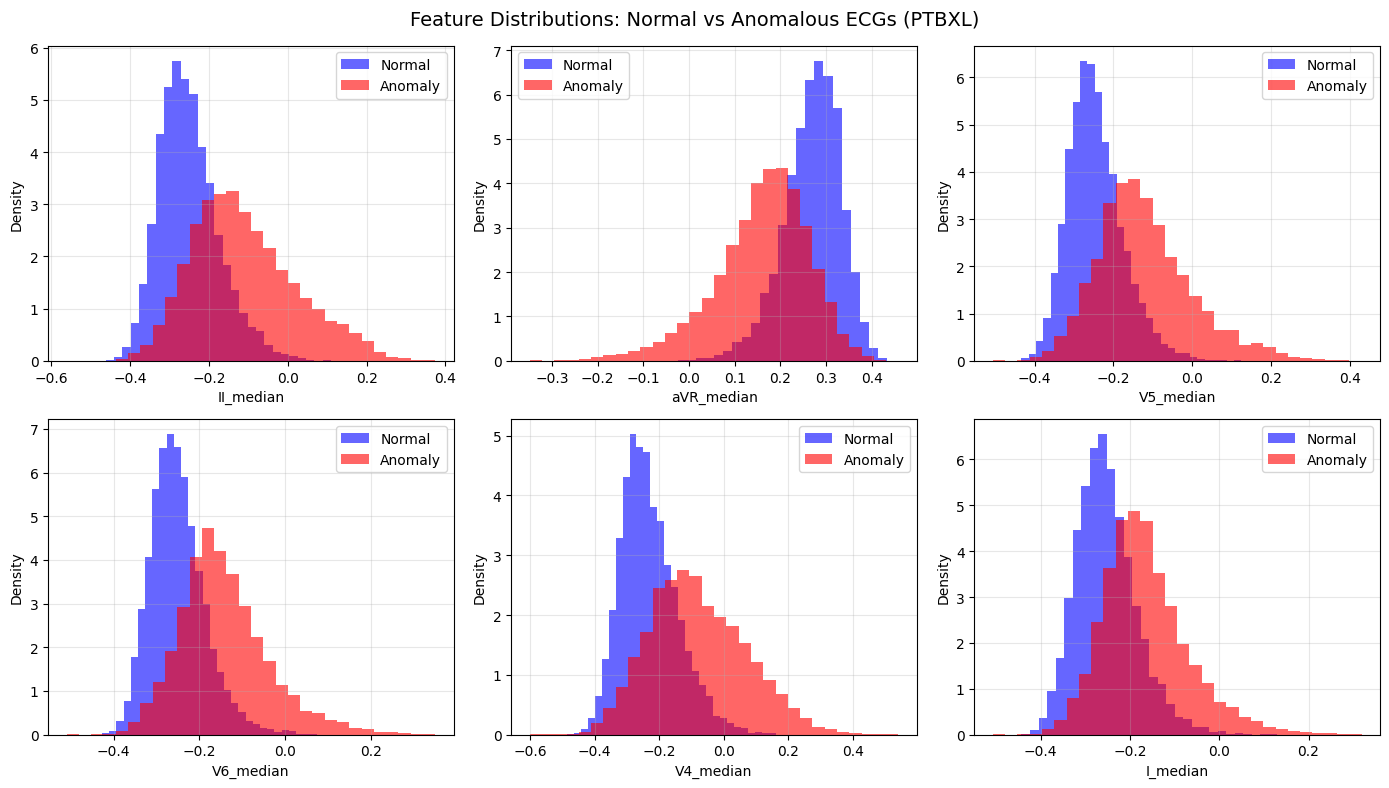

In [51]:
# Visualize Feature Distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ax, feat_name in zip(axes.flat, key_features):
    if feat_name in feature_extractor.feature_names:
        feat_idx = feature_extractor.feature_names.index(feat_name)
        
        normal_vals = X_train_features[y_train == 0, feat_idx]
        anomaly_vals = X_train_features[y_train == 1, feat_idx]
        
        ax.hist(normal_vals, bins=30, alpha=0.6, label='Normal', color='blue', density=True)
        ax.hist(anomaly_vals, bins=30, alpha=0.6, label='Anomaly', color='red', density=True)
        ax.set_xlabel(feat_name)
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle('Feature Distributions: Normal vs Anomalous ECGs (PTBXL)', fontsize=14)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Detection Layer

Compare 4 novelty detection methods:
- **CNN Autoencoder**: Deep learning, reconstruction error
- **Isolation Forest**: Tree-based isolation
- **One-Class SVM**: Kernel-based boundary
- **Local Outlier Factor**: Density-based

In [52]:
class AnomalyDetector(ABC):
    @abstractmethod
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'AnomalyDetector':
        pass
    
    @abstractmethod
    def predict(self, X: np.ndarray) -> np.ndarray:
        pass
    
    @abstractmethod
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        pass

In [53]:
class IsolationForestDetector(AnomalyDetector):
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.model = IsolationForest(
            n_estimators=config.if_n_estimators,
            max_samples=config.if_max_samples,
            contamination='auto',
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        self.threshold = 0.0
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'IsolationForestDetector':
        X_normal = X[y == 0] if y is not None else X
        print(f"Isolation Forest: Training on {len(X_normal)} normal samples")
        self.model.fit(X_normal)
        normal_scores = self.decision_function(X_normal)
        self.threshold = np.percentile(normal_scores, self.config.contamination * 100)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.decision_function(X) >= self.threshold).astype(int)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return -self.model.decision_function(X)

In [54]:
class OCSVMDetector(AnomalyDetector):
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.model = OneClassSVM(
            kernel=config.svm_kernel,
            nu=config.svm_nu,
            gamma=config.svm_gamma
        )
        self.threshold = 0.0
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'OCSVMDetector':
        X_normal = X[y == 0] if y is not None else X
        print(f"One-Class SVM: Training on {len(X_normal)} normal samples")
        self.model.fit(X_normal)
        normal_scores = self.decision_function(X_normal)
        self.threshold = np.percentile(normal_scores, self.config.contamination * 100)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.decision_function(X) >= self.threshold).astype(int)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return -self.model.decision_function(X)

In [55]:
class LOFDetector(AnomalyDetector):
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.model = LocalOutlierFactor(
            n_neighbors=config.lof_n_neighbors,
            contamination='auto',
            novelty=True,
            n_jobs=-1
        )
        self.threshold = 0.0
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'LOFDetector':
        X_normal = X[y == 0] if y is not None else X
        print(f"Local Outlier Factor: Training on {len(X_normal)} normal samples")
        self.model.fit(X_normal)
        normal_scores = self.decision_function(X_normal)
        self.threshold = np.percentile(normal_scores, self.config.contamination * 100)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.decision_function(X) >= self.threshold).astype(int)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return -self.model.decision_function(X)

In [56]:
# CNN Autoencoder
class TimeSeriesDataset(Dataset):
    def __init__(self, signals: np.ndarray):
        X = np.array(signals, dtype=np.float32)
        X = np.transpose(X, (0, 2, 1))  # (samples, channels(leads), timesteps)
        self.X = torch.tensor(X, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.X[idx]


class TimeSeries1DAutoEncoder(nn.Module):
    def __init__(self, n_channels: int = 12, signal_length: int = 1000):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.ConvTranspose1d(32, n_channels, kernel_size=7, stride=2, padding=3, output_padding=1),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Match input size
        if decoded.shape[2] != x.shape[2]:
            decoded = torch.nn.functional.interpolate(decoded, size=x.shape[2], mode='linear', align_corners=False)
        return decoded


class CNNAutoencoderDetector(AnomalyDetector):
    def __init__(self, config: PipelineConfig):
        self.config = config
        # TODO change to mps
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = TimeSeries1DAutoEncoder(config.n_channels, config.signal_length).to(self.device)
        self.threshold = 0.0
        self.training_losses = []
        self.validation_losses = []
        self.normal_mean_error = 0.0
        self.normal_std_error = 0.0
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'CNNAutoencoderDetector':
        X_normal = X[y == 0] if y is not None else X
        print(f"CNN Autoencoder: Training on {len(X_normal)} normal samples")
        
        # Split into train/val
        from sklearn.model_selection import train_test_split
        X_train_split, X_val_split = train_test_split(
            X_normal, test_size=0.15, random_state=RANDOM_STATE
        )
        
        train_dataset = TimeSeriesDataset(X_train_split)
        val_dataset = TimeSeriesDataset(X_val_split)
        train_loader = DataLoader(train_dataset, batch_size=self.config.cnn_batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.config.cnn_batch_size, shuffle=False)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.cnn_lr,
                                     weight_decay=self.config.cnn_weight_decay)
        criterion = nn.MSELoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
        
        best_val_loss = float('inf')
        best_state = None
        
        for epoch in range(self.config.cnn_epochs):
            # Training
            self.model.train()
            train_loss = 0.0
            for batch_x, _ in train_loader:
                batch_x = batch_x.to(self.device)
                optimizer.zero_grad()
                output = self.model(batch_x)
                loss = criterion(output, batch_x)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * batch_x.size(0)
            
            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_x, _ in val_loader:
                    batch_x = batch_x.to(self.device)
                    output = self.model(batch_x)
                    loss = criterion(output, batch_x)
                    val_loss += loss.item() * batch_x.size(0)
            
            train_loss /= len(train_dataset)
            val_loss /= len(val_dataset)
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            
            scheduler.step(val_loss)
            
            # Print every epoch
            print(f"    Epoch {epoch+1}/{self.config.cnn_epochs} - train_loss={train_loss:.6f} val_loss={val_loss:.6f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
        
        # Load best model
        if best_state is not None:
            self.model.load_state_dict(best_state)
        
        # Calculate reconstruction errors on normal training data
        normal_errors = self.decision_function(X_normal)
        self.normal_mean_error = np.mean(normal_errors)
        self.normal_std_error = np.std(normal_errors)
        
        # Set threshold
        self.threshold = np.percentile(normal_errors, self.config.cnn_reconstruction_percentile)
        
        print(f"\n    Reconstruction Error Statistics (Normal Data):")
        print(f"      Mean: {self.normal_mean_error:.6f}")
        print(f"      Std:  {self.normal_std_error:.6f}")
        print(f"      Min:  {np.min(normal_errors):.6f}")
        print(f"      Max:  {np.max(normal_errors):.6f}")
        print(f"    Threshold set at {self.config.cnn_reconstruction_percentile}th percentile: {self.threshold:.6f}")
        
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.decision_function(X) >= self.threshold).astype(int)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        self.model.eval()
        dataset = TimeSeriesDataset(X)
        loader = DataLoader(dataset, batch_size=self.config.cnn_batch_size, shuffle=False)
        
        errors = []
        with torch.no_grad():
            for batch_x, _ in loader:
                batch_x = batch_x.to(self.device)
                output = self.model(batch_x)
                mse = torch.mean((output - batch_x) ** 2, dim=(1, 2))
                errors.extend(mse.cpu().numpy())
        
        return np.array(errors)

In [58]:
def evaluate_detector(detector: AnomalyDetector, X: np.ndarray, y: np.ndarray, name: str) -> Dict[str, float]:
    y_pred = detector.predict(X)
    scores = detector.decision_function(X)
    
    metrics = {
        'AUROC': roc_auc_score(y, scores),
        'AUPRC': average_precision_score(y, scores),
        'F1': f1_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0)
    }
    
    print(f"\n{'='*50}")
    print(f"{name} Results:")
    print(f"{'='*50}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    
    cm = confusion_matrix(y, y_pred)
    print(f"\n  Confusion Matrix:")
    print(f"  TN={cm[0,0]}, FP={cm[0,1]}")
    print(f"  FN={cm[1,0]}, TP={cm[1,1]}")
    print(f"\n")
    
    return metrics

In [59]:
# Train all detectors
print("="*70)
print("TRAINING NOVELTY DETECTORS")
print("="*70,"\n")


detectors = {}
all_metrics = {}

DETECTOR_NAMES = {
    'isolation_forest': 'Isolation Forest',
    'ocsvm': 'One-Class SVM',
    'lof': 'Local Outlier Factor',
    'cnn_autoencoder': 'CNN Autoencoder'
}

# Isolation Forest
detectors['isolation_forest'] = IsolationForestDetector(config)
detectors['isolation_forest'].fit(X_train_scaled, y_train)
all_metrics['isolation_forest'] = evaluate_detector(detectors['isolation_forest'], X_test_scaled, y_test, 'isolation_forest')

# One-Class SVM
detectors['ocsvm'] = OCSVMDetector(config)
detectors['ocsvm'].fit(X_train_scaled, y_train)
all_metrics['ocsvm'] = evaluate_detector(detectors['ocsvm'], X_test_scaled, y_test, 'ocsvm')

# LOF
detectors['lof'] = LOFDetector(config)
detectors['lof'].fit(X_train_scaled, y_train)
all_metrics['lof'] = evaluate_detector(detectors['lof'], X_test_scaled, y_test, 'lof')

# CNN Autoencoder
detectors['cnn_autoencoder'] = CNNAutoencoderDetector(config)
detectors['cnn_autoencoder'].fit(X_train, y_train)
all_metrics['cnn_autoencoder'] = evaluate_detector(detectors['cnn_autoencoder'], X_test, y_test, 'cnn_autoencoder')

TRAINING NOVELTY DETECTORS

Isolation Forest: Training on 8129 normal samples

isolation_forest Results:
  AUROC: 0.8670
  AUPRC: 0.8893
  F1: 0.7344
  Precision: 0.5821
  Recall: 0.9947

  Confusion Matrix:
  TN=94, FP=815
  FN=6, TP=1135


One-Class SVM: Training on 8129 normal samples

ocsvm Results:
  AUROC: 0.8423
  AUPRC: 0.8525
  F1: 0.7332
  Precision: 0.5806
  Recall: 0.9947

  Confusion Matrix:
  TN=89, FP=820
  FN=6, TP=1135


Local Outlier Factor: Training on 8129 normal samples

lof Results:
  AUROC: 0.8432
  AUPRC: 0.8579
  F1: 0.7313
  Precision: 0.5782
  Recall: 0.9947

  Confusion Matrix:
  TN=81, FP=828
  FN=6, TP=1135


CNN Autoencoder: Training on 8129 normal samples
    Epoch 1/30 - train_loss=0.692700 val_loss=0.637011
    Epoch 2/30 - train_loss=0.618088 val_loss=0.614595
    Epoch 3/30 - train_loss=0.598653 val_loss=0.602786
    Epoch 4/30 - train_loss=0.585380 val_loss=0.591018
    Epoch 5/30 - train_loss=0.577013 val_loss=0.589851
    Epoch 6/30 - train_loss=0

In [60]:
# Results Table
results_df = pd.DataFrame(all_metrics).T
results_df = results_df.round(4)

print("\n" + "="*70)
print("DETECTION COMPARISON")
print("="*70)
print(results_df.to_string())

# Highlight best
print(f"\nBest AUROC: {results_df['AUROC'].idxmax()} ({results_df['AUROC'].max():.4f})")
print(f"Best F1: {results_df['F1'].idxmax()} ({results_df['F1'].max():.4f})")


DETECTION COMPARISON
                   AUROC   AUPRC      F1  Precision  Recall
isolation_forest  0.8670  0.8893  0.7344     0.5821  0.9947
ocsvm             0.8423  0.8525  0.7332     0.5806  0.9947
lof               0.8432  0.8579  0.7313     0.5782  0.9947
cnn_autoencoder   0.5979  0.6690  0.3698     0.7344  0.2472

Best AUROC: isolation_forest (0.8670)
Best F1: isolation_forest (0.7344)


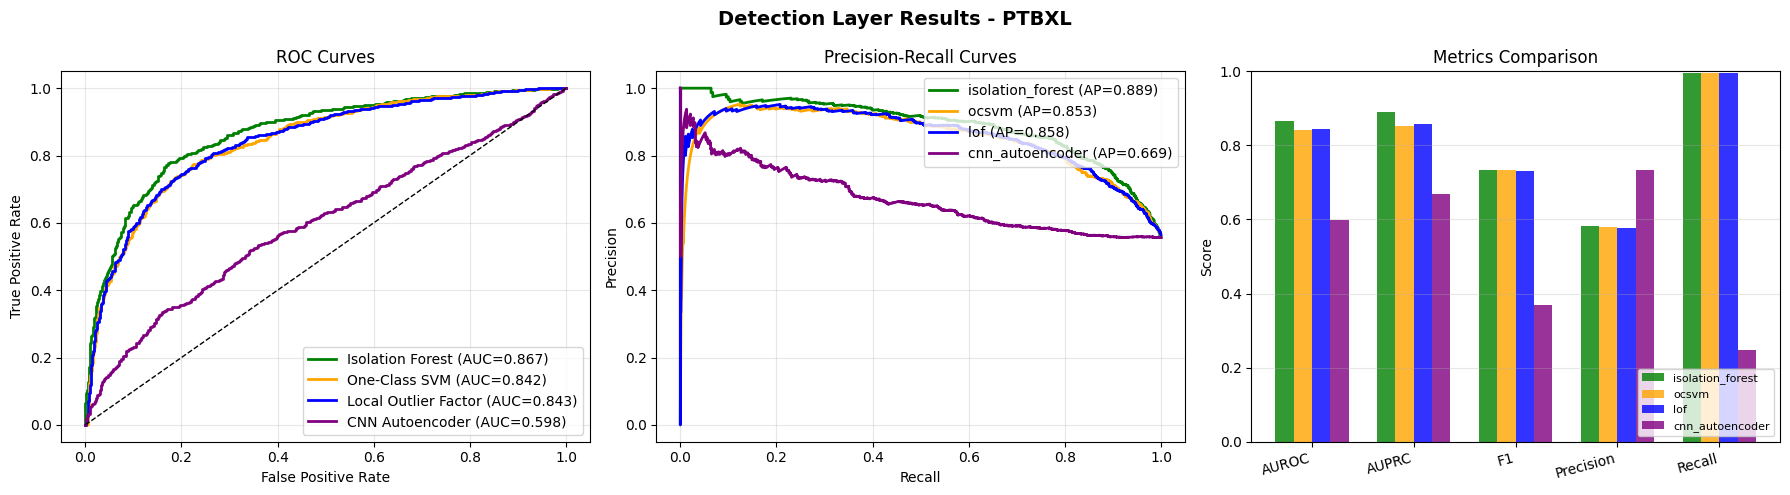

In [61]:
# ROC and PR Curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = {'isolation_forest': 'green', 'ocsvm': 'orange', 'lof': 'blue', 'cnn_autoencoder': 'purple'}

detector_scores = {
    'isolation_forest': detectors['isolation_forest'].decision_function(X_test_scaled),
    'ocsvm': detectors['ocsvm'].decision_function(X_test_scaled),
    'lof': detectors['lof'].decision_function(X_test_scaled),
    'cnn_autoencoder': detectors['cnn_autoencoder'].decision_function(X_test)
}

# ROC Curves
for key, scores in detector_scores.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    axes[0].plot(fpr, tpr, label=f'{DETECTOR_NAMES[key]} (AUC={auc:.3f})', color=colors[key], linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# PR Curves
for name, scores in detector_scores.items():
    precision, recall, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    axes[1].plot(recall, precision, label=f'{name} (AP={ap:.3f})', color=colors[name], linewidth=2)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# Metrics comparison bar chart
metrics_to_plot = ['AUROC', 'AUPRC', 'F1', 'Precision', 'Recall']
x = np.arange(len(metrics_to_plot))
width = 0.18  

for i, (name, metrics) in enumerate(all_metrics.items()):
    values = [metrics[m] for m in metrics_to_plot]
    axes[2].bar(x + i*width, values, width, label=name, color=colors[name], alpha=0.8)

axes[2].set_ylabel('Score')
axes[2].set_title('Metrics Comparison')
axes[2].set_xticks(x + width * 1.5)
axes[2].set_xticklabels(metrics_to_plot, rotation=15, ha='right')
axes[2].legend(loc='lower right', fontsize=8)
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim(0, 1)

plt.suptitle('Detection Layer Results - PTBXL', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('detection_results.png', dpi=150, bbox_inches='tight')
plt.show()

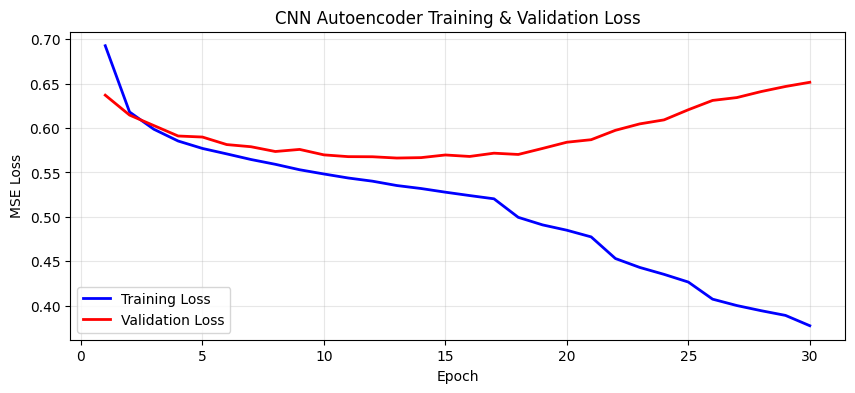

In [62]:
# CNN Autoencoder training curves
if hasattr(detectors['cnn_autoencoder'], 'training_losses'):
    fig, ax = plt.subplots(figsize=(10, 4))
    epochs = range(1, len(detectors['cnn_autoencoder'].training_losses) + 1)
    
    ax.plot(epochs, detectors['cnn_autoencoder'].training_losses, 'b-', linewidth=2, label='Training Loss')
    if hasattr(detectors['cnn_autoencoder'], 'validation_losses'):
        ax.plot(epochs, detectors['cnn_autoencoder'].validation_losses, 'r-', linewidth=2, label='Validation Loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE Loss')
    ax.set_title('CNN Autoencoder Training & Validation Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.savefig('cnn_training_loss.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 6. Counterfactual Layer

Generate nearest-neighbour counterfactuals and evaluate quality metrics.

In [63]:
@dataclass
class CounterfactualResult:
    # Original
    original_idx: int
    original_signal: np.ndarray
    original_features: np.ndarray
    original_score: float
    
    # Counterfactual
    cf_idx: int
    cf_signal: np.ndarray
    cf_features: np.ndarray
    cf_score: float
    
    # Quality metrics
    validity: bool = False
    proximity: float = 0.0
    sparsity: int = 0
    
    # Feature differences
    feature_differences: Dict[str, Tuple[float, float, float]] = field(default_factory=dict)  
    top_changes: List[Tuple[str, float, float, float]] = field(default_factory=list)  

In [64]:
class NearestNeighbourCounterfactual:
    def __init__(self, config: PipelineConfig, detector: AnomalyDetector,
                 feature_names: List[str], uses_features: bool = True):
        self.config = config
        self.detector = detector
        self.feature_names = feature_names
        self.uses_features = uses_features
        self.nn_model = None
        self.normal_signals = None
        self.normal_features = None
        self.normal_features_scaled = None
    
    def fit(self, X_signals: np.ndarray, X_features_scaled: np.ndarray, y: np.ndarray):
        normal_mask = (y == 0)
        self.normal_signals = X_signals[normal_mask]
        self.normal_features_scaled = X_features_scaled[normal_mask]
        
        self.nn_model = NearestNeighbors(
            n_neighbors=min(self.config.cf_search_k, len(self.normal_features_scaled)),
            metric=self.config.distance_metric
        )
        self.nn_model.fit(self.normal_features_scaled)
        print(f"  Counterfactual generator fitted on {len(self.normal_signals)} normal samples")
    
    def generate(self, idx: int, signal: np.ndarray, features_scaled: np.ndarray) -> CounterfactualResult:
        # Get original score
        if self.uses_features:
            original_score = self.detector.decision_function(features_scaled.reshape(1, -1))[0]
        else:
            original_score = self.detector.decision_function(signal[np.newaxis, ...])[0]
        
        # Find nearest normal neighbour
        distances, indices = self.nn_model.kneighbors(features_scaled.reshape(1, -1))
        cf_idx = indices[0, 0]
        
        cf_signal = self.normal_signals[cf_idx]
        cf_features_scaled = self.normal_features_scaled[cf_idx]
        
        # Get CF score
        if self.uses_features:
            cf_score = self.detector.decision_function(cf_features_scaled.reshape(1, -1))[0]
            cf_pred = self.detector.predict(cf_features_scaled.reshape(1, -1))[0]
        else:
            cf_score = self.detector.decision_function(cf_signal[np.newaxis, ...])[0]
            cf_pred = self.detector.predict(cf_signal[np.newaxis, ...])[0]
        
        # Calculate metrics
        validity = (cf_pred == 0) 
        proximity = distances[0, 0]
        
        # Feature differences
        diffs = cf_features_scaled - features_scaled
        sparsity = int(np.sum(np.abs(diffs) > 0.5))  
        
        # Top changes
        feature_diffs = {}
        for i, name in enumerate(self.feature_names):
            feature_diffs[name] = (features_scaled[i], cf_features_scaled[i], diffs[i])
        
        # Sort by absolute difference
        sorted_diffs = sorted(feature_diffs.items(), key=lambda x: abs(x[1][2]), reverse=True)
        top_changes = [(name, orig, cf, diff) for name, (orig, cf, diff) in sorted_diffs[:10]]
        
        return CounterfactualResult(
            original_idx=idx,
            original_signal=signal,
            original_features=features_scaled,
            original_score=original_score,
            cf_idx=cf_idx,
            cf_signal=cf_signal,
            cf_features=cf_features_scaled,
            cf_score=cf_score,
            validity=validity,
            proximity=proximity,
            sparsity=sparsity,
            feature_differences=feature_diffs,
            top_changes=top_changes
        )

In [67]:
# Select primary detector
primary_detector = detectors[config.primary_detector]
uses_features = config.primary_detector != 'cnn_autoencoder'

print(f"Primary detector: {DETECTOR_NAMES[config.primary_detector]}")
print(f"Uses features: {uses_features}")

# Initialize counterfactual generator
cf_generator = NearestNeighbourCounterfactual(
    config=config,
    detector=primary_detector,
    feature_names=feature_extractor.feature_names,
    uses_features=uses_features
)
cf_generator.fit(X_train, X_train_scaled, y_train)

Primary detector: Isolation Forest
Uses features: True
  Counterfactual generator fitted on 8129 normal samples


In [68]:
# Generate counterfactuals for all test anomalies
anomaly_indices = np.where(y_test == 1)[0]

counterfactuals = []
for idx in tqdm(anomaly_indices, desc="Generating CFs"):
    cf = cf_generator.generate(idx, X_test[idx], X_test_scaled[idx])
    counterfactuals.append(cf)

Generating CFs: 100%|██████████| 1141/1141 [00:37<00:00, 30.22it/s]


In [69]:
# Counterfactual Quality Summary
validity_rate = sum(cf.validity for cf in counterfactuals) / len(counterfactuals)
mean_proximity = np.mean([cf.proximity for cf in counterfactuals])
std_proximity = np.std([cf.proximity for cf in counterfactuals])
mean_sparsity = np.mean([cf.sparsity for cf in counterfactuals])
std_sparsity = np.std([cf.sparsity for cf in counterfactuals])

print("\n" + "="*70)
print("COUNTERFACTUAL QUALITY SUMMARY")
print("="*70)
print(f"  Validity Rate:  {validity_rate:.2%}")
print(f"  Proximity:      {mean_proximity:.4f} ± {std_proximity:.4f}")
print(f"  Sparsity:       {mean_sparsity:.1f} ± {std_sparsity:.1f} features")

cf_quality_df = pd.DataFrame({
    'Metric': ['Validity Rate', 'Mean Proximity', 'Mean Sparsity'],
    'Value': [f"{validity_rate:.2%}", f"{mean_proximity:.4f}", f"{mean_sparsity:.1f}"],
    'Std': ['-', f"± {std_proximity:.4f}", f"± {std_sparsity:.1f}"]
})
print("\n")
print(cf_quality_df.to_string(index=False))


COUNTERFACTUAL QUALITY SUMMARY
  Validity Rate:  5.61%
  Proximity:      16.6800 ± 3.3249
  Sparsity:       170.3 ± 31.5 features


        Metric   Value      Std
 Validity Rate   5.61%        -
Mean Proximity 16.6800 ± 3.3249
 Mean Sparsity   170.3   ± 31.5


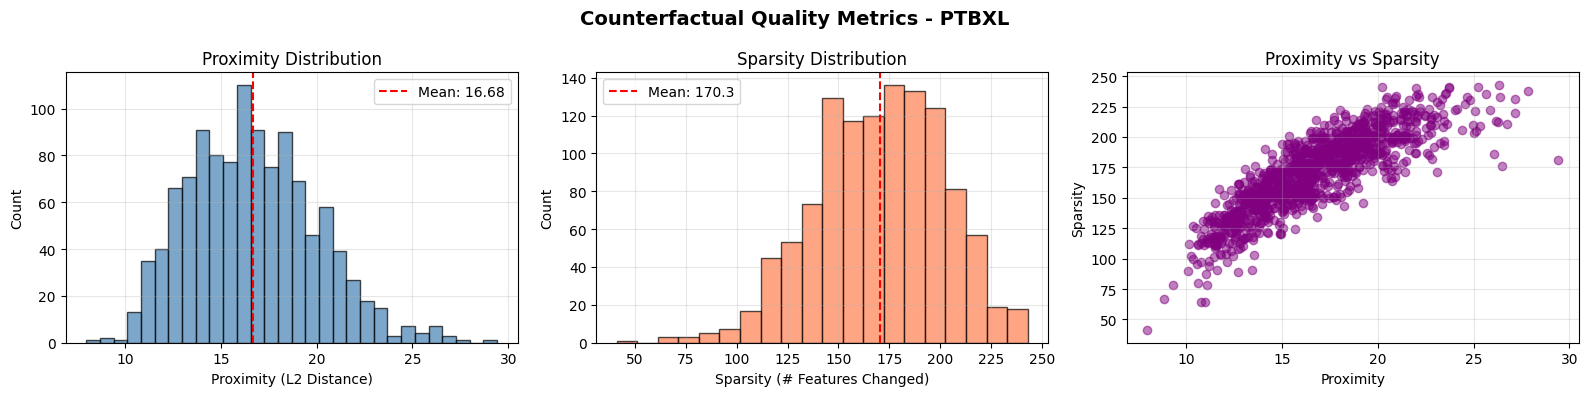

In [70]:
# Counterfactual quality visualisation
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# proximity distribution
proximities = [cf.proximity for cf in counterfactuals]
axes[0].hist(proximities, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(mean_proximity, color='red', linestyle='--', label=f'Mean: {mean_proximity:.2f}')
axes[0].set_xlabel('Proximity (L2 Distance)')
axes[0].set_ylabel('Count')
axes[0].set_title('Proximity Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sparsity distribution
sparsities = [cf.sparsity for cf in counterfactuals]
axes[1].hist(sparsities, bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(mean_sparsity, color='red', linestyle='--', label=f'Mean: {mean_sparsity:.1f}')
axes[1].set_xlabel('Sparsity (# Features Changed)')
axes[1].set_ylabel('Count')
axes[1].set_title('Sparsity Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Proximity vs Sparsity
axes[2].scatter(proximities, sparsities, alpha=0.5, c='purple')
axes[2].set_xlabel('Proximity')
axes[2].set_ylabel('Sparsity')
axes[2].set_title('Proximity vs Sparsity')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Counterfactual Quality Metrics - PTBXL', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('counterfactual_quality.png', dpi=150, bbox_inches='tight')
plt.show()

In [71]:
def visualize_counterfactual(cf: CounterfactualResult, title: str = ""):
    fig = plt.figure(figsize=(20, 14))
    
    for lead_idx in range(12):
        ax = fig.add_subplot(4, 6, lead_idx + 1)
        ax.plot(cf.original_signal[:, lead_idx], 'r-', label='Original (Anomalous ECG)', linewidth=1, alpha=0.8)
        ax.plot(cf.cf_signal[:, lead_idx], 'b-', label='Counterfactual (Normal Reference)', linewidth=1, alpha=0.8)
        ax.set_title(f'{LEAD_NAMES[lead_idx]}', fontsize=10)
        ax.grid(True, alpha=0.3)
        if lead_idx == 0:
            ax.legend(fontsize=8)
    
    # Top feature changes
    ax_feat = fig.add_subplot(4, 2, 5)
    top_n = min(8, len(cf.top_changes))
    names = [c[0][:15] for c in cf.top_changes[:top_n]] 
    orig_vals = [c[1] for c in cf.top_changes[:top_n]]
    cf_vals = [c[2] for c in cf.top_changes[:top_n]]

    x = np.arange(top_n)
    width = 0.35
    ax_feat.bar(x - width/2, orig_vals, width, label='Original (Anomalous)', color='red', alpha=0.7)
    ax_feat.bar(x + width/2, cf_vals, width, label='Counterfactual (Normal)', color='blue', alpha=0.7)
    ax_feat.set_xticks(x)
    ax_feat.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
    ax_feat.set_ylabel('Feature Value (scaled)')
    ax_feat.set_title('Top Feature Changes')
    ax_feat.legend(loc='upper right', fontsize=8)
    ax_feat.grid(True, alpha=0.3, axis='y')
    
    # Quality metrics text
    ax_text = fig.add_subplot(4, 2, 6)
    ax_text.axis('off')
    
    metrics_text = f"""
    COUNTERFACTUAL QUALITY
    {'='*35}
    
    Validity:   {'VALID' if cf.validity else 'INVALID'}
    Proximity:  {cf.proximity:.4f}
    Sparsity:   {cf.sparsity} features changed
    
    Anomaly Score:    {cf.original_score:.4f}
    Normal CF Score:  {cf.cf_score:.4f}
    
    TOP CHANGES:
    """
    for name, orig, cf_val, diff in cf.top_changes[:5]:
        direction = "↑" if diff > 0 else "↓"
        metrics_text += f"\n    • {name[:25]}: {direction} {abs(diff):.2f}"
    
    ax_text.text(0.05, 0.95, metrics_text, transform=ax_text.transAxes, fontsize=10,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle(title or 'Counterfactual Explanation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


Example Counterfactuals:


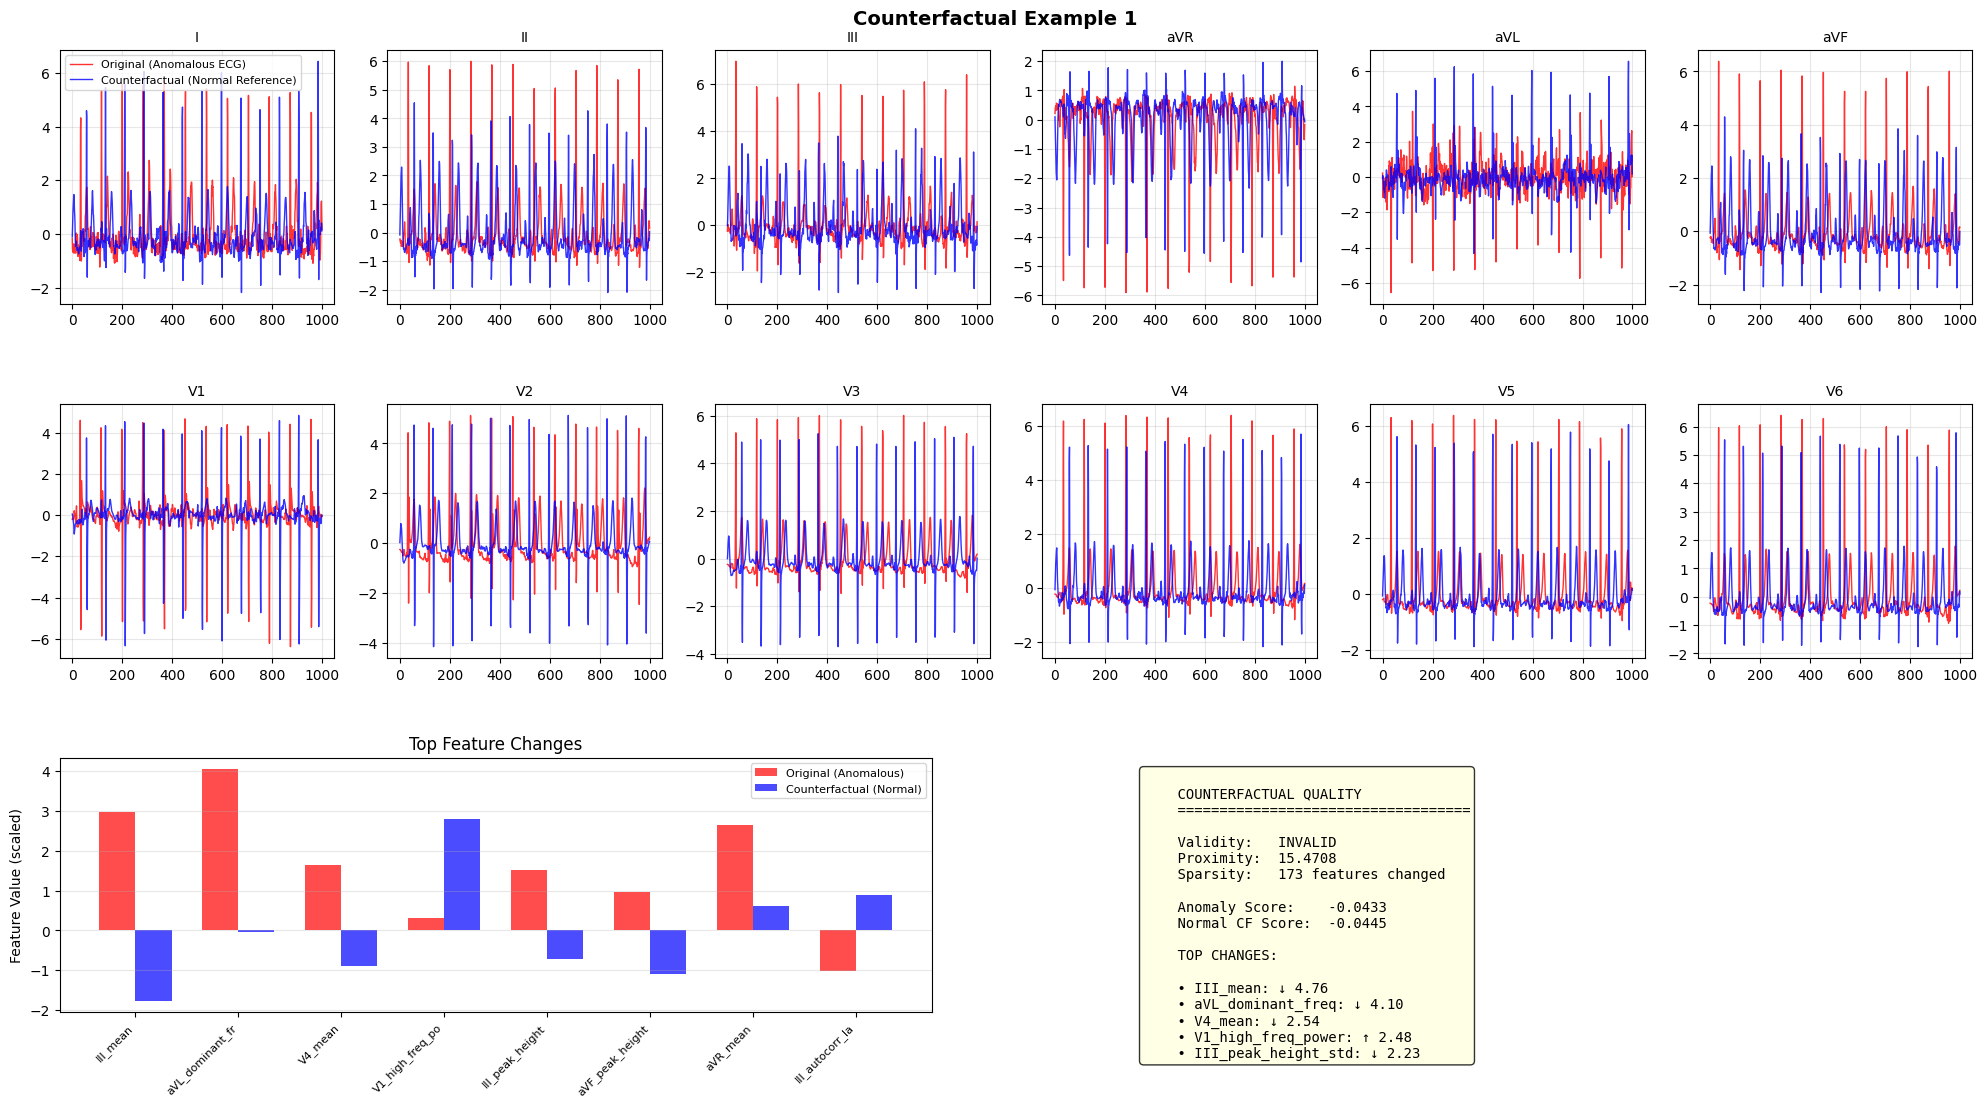

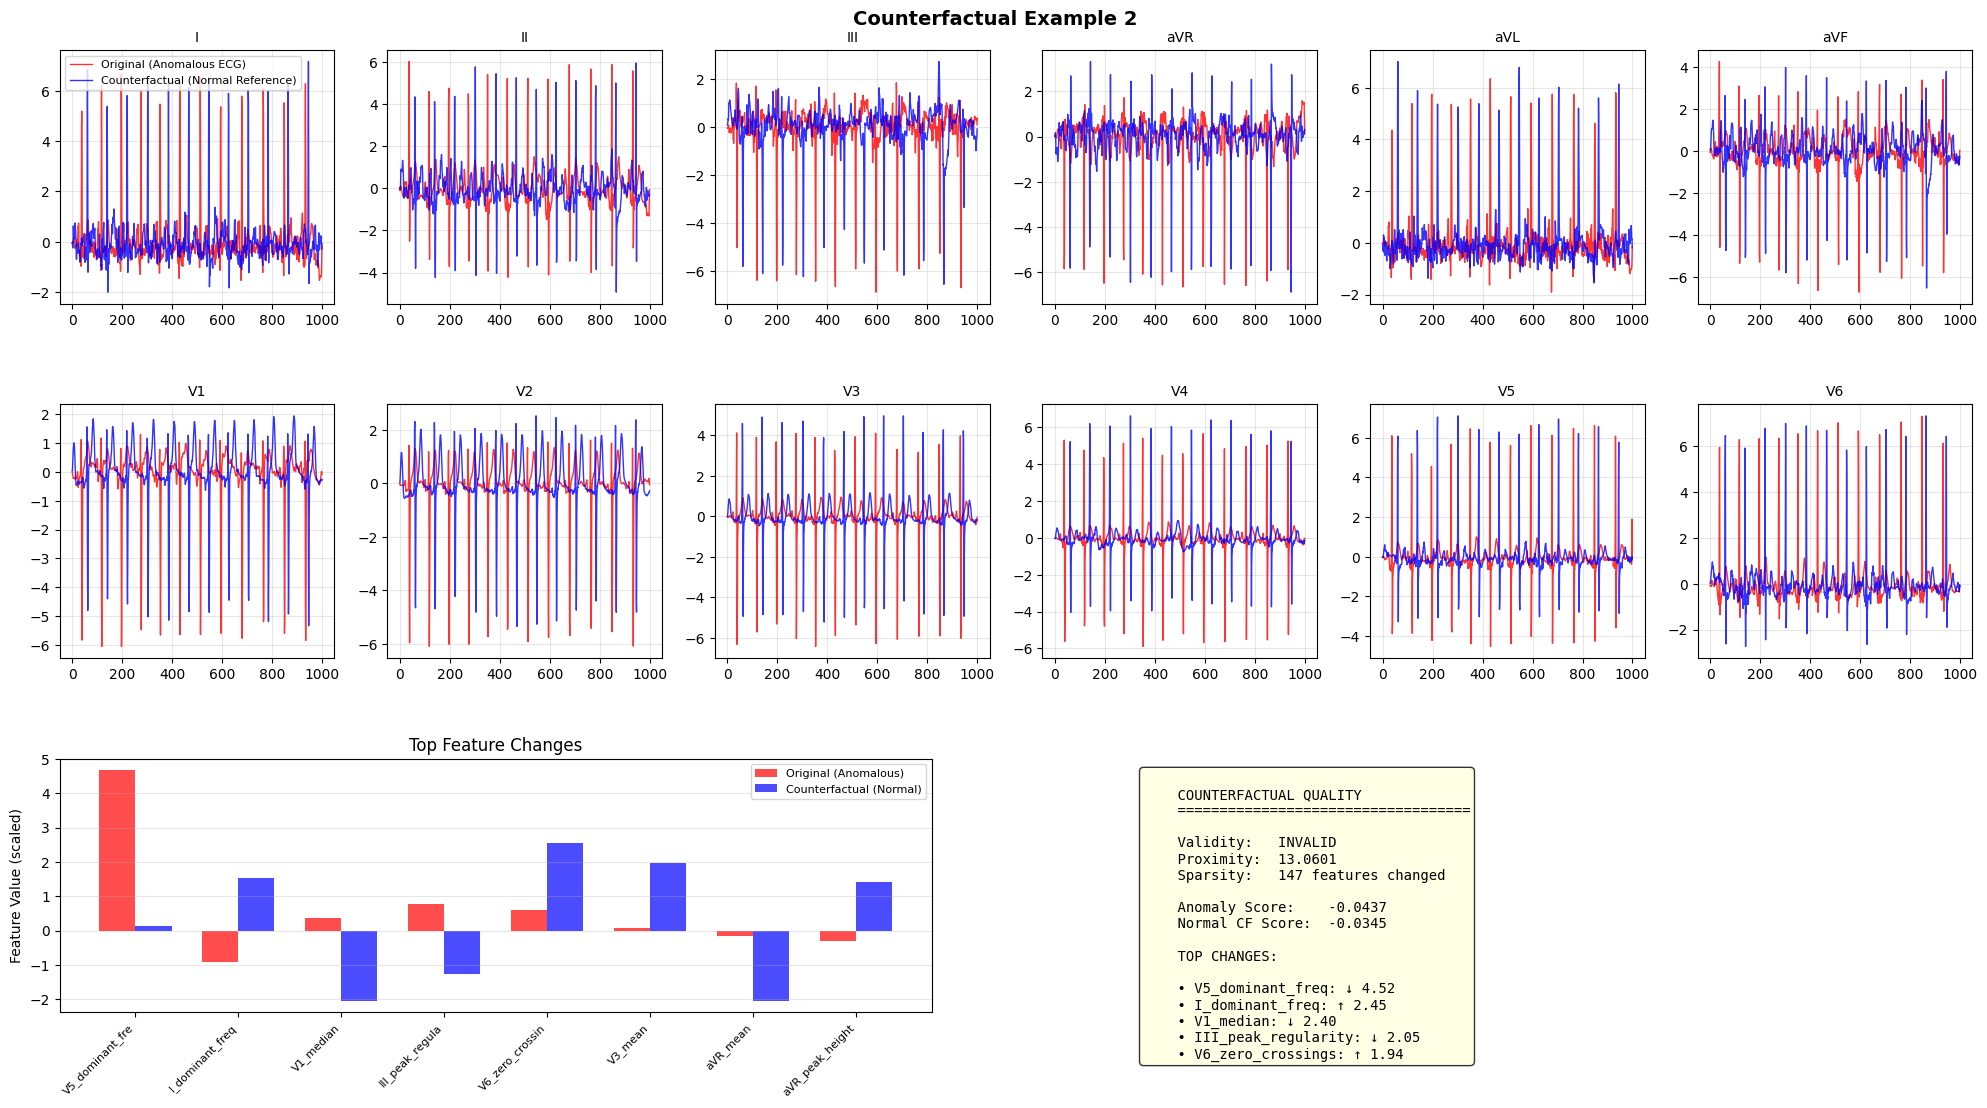

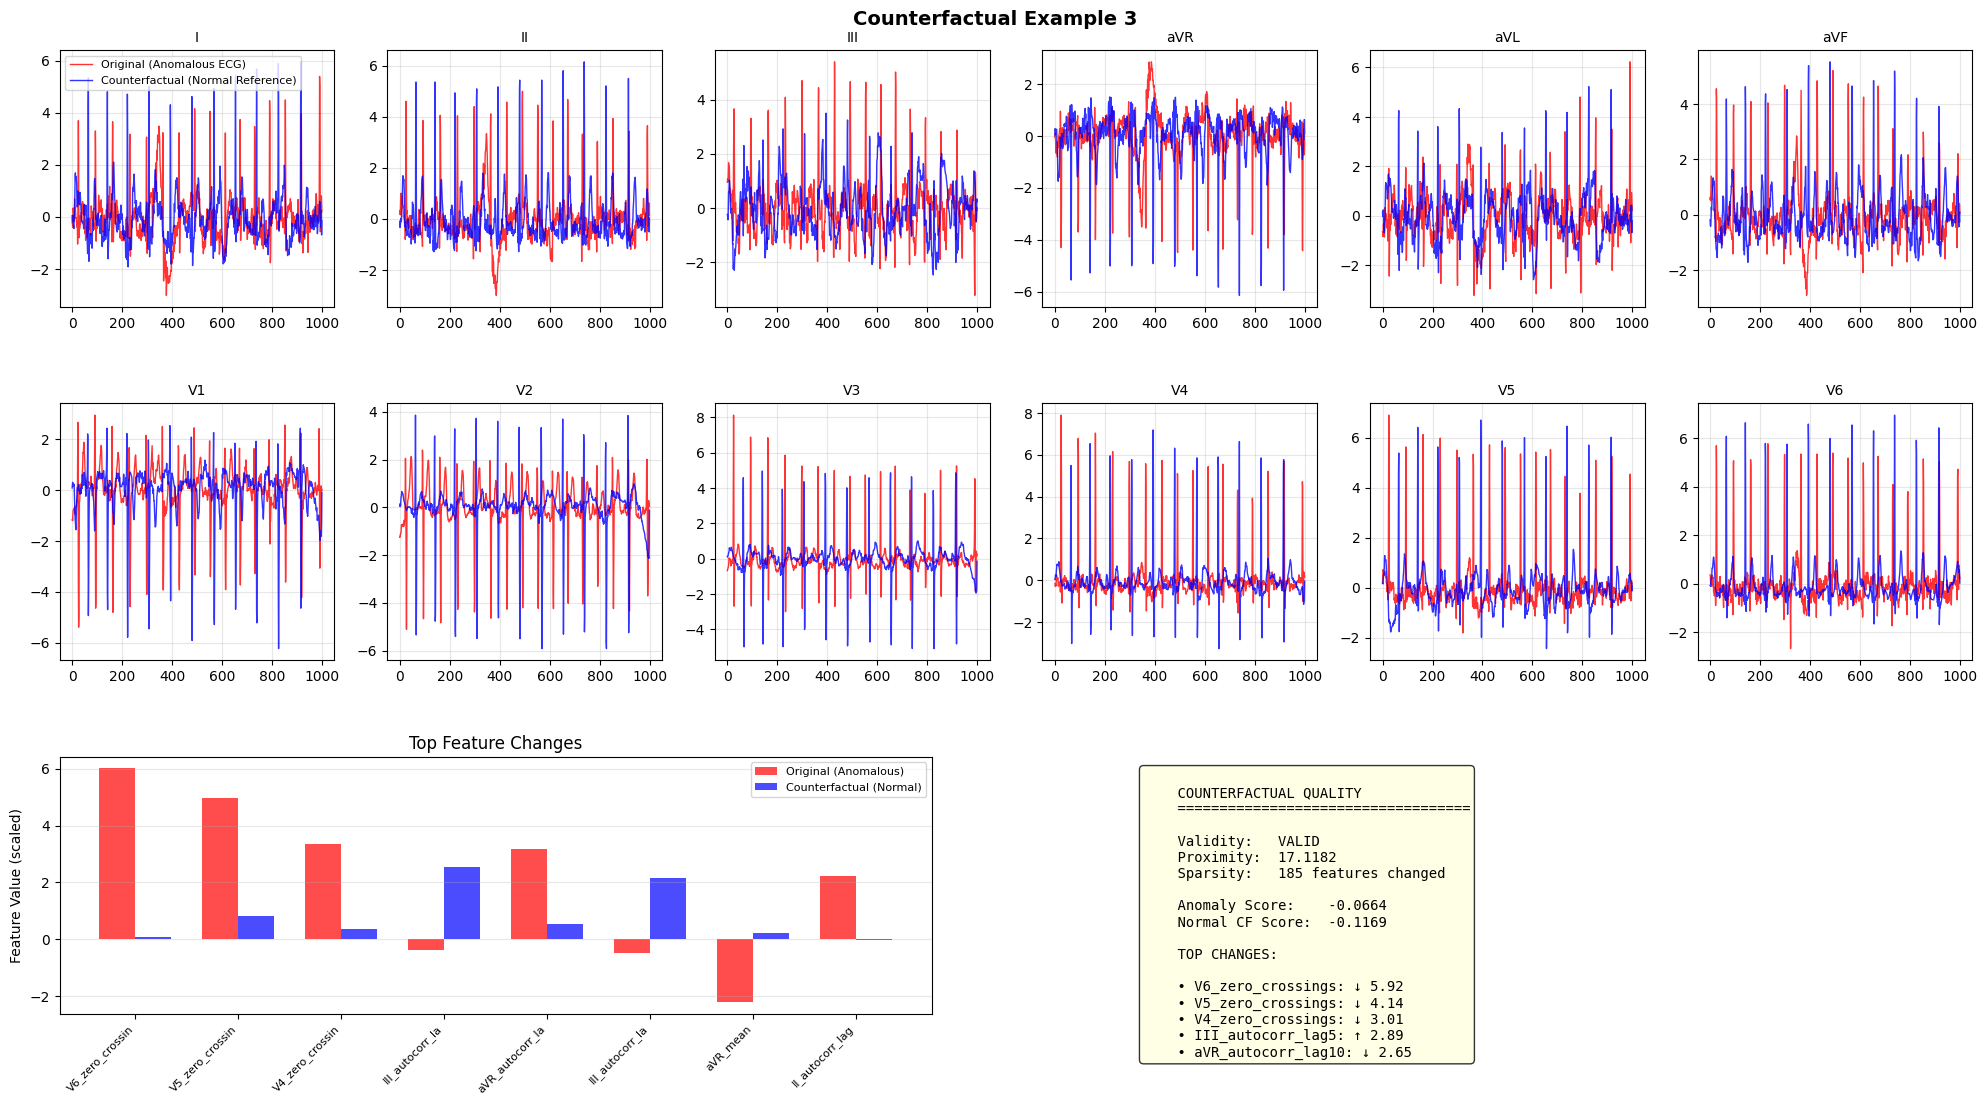

In [72]:
# Visualize example counterfactuals
print("\nExample Counterfactuals:")
for i in range(min(3, len(counterfactuals))):
    fig = visualize_counterfactual(counterfactuals[i], f"Counterfactual Example {i+1}")
    plt.savefig(f'cf_example_{i+1}.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 8. Summary & Export

In [ ]:
results_df.to_csv('detection_results.csv')

# Summary dict
summary = {
    'dataset': 'PTBXL',
    'n_train': len(X_train),
    'n_test': len(X_test),
    'n_anomalies_test': int(sum(y_test)),
    'detection': all_metrics,
    'counterfactual': {
        'validity_rate': validity_rate,
        'mean_proximity': float(mean_proximity),
        'mean_sparsity': float(mean_sparsity)
    }
}

with open('pipeline_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\nResults exported:")
print("  - detection_results.csv")
print("  - pipeline_summary.json")
print("  - detection_results.png")
print("  - counterfactual_quality.png")
print("  - cf_example_*.png")


✓ Results exported:
  - detection_results.csv
  - pipeline_summary.json
  - detection_results.png
  - counterfactual_quality.png
  - cf_example_*.png
